# Read a NetCDF for xz-time PDE solved on triangular unstructured grid


    -Authors: Niccolò Tubini and Riccardo Rigon
    -License: Creative Commons 4.0


In [1]:
# %%capture
# %run ???.py

#from netCDF4_classic import Dataset
from netCDF4 import Dataset


import os

## pandas
import pandas as pd

## numpy
import numpy as np

## plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#import matplotlib.transforms as transforms
#import matplotlib.gridspec as gridspec
#import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib import rc

## to convert unix time to human readable date
import time
import datetime


import scipy.interpolate as interp
#################
# Plot settings #
#################

# FIGURE SIZE
AxesWidth  = 15; #inch
AxesHeight = AxesWidth/1.618; # inch
plt.rc('figure', figsize=(AxesWidth,AxesHeight))

# AXES
plt.rc('axes', edgecolor='black',axisbelow=True, grid=True)

# GRID
plt.rc('grid', color='lightgray', linestyle='solid')

# TICKS
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
# FONTS
font = {'family' : 'sans-serif','weight' : 'normal','size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')


Set in the output folder of the the OMS project

In [2]:
os.chdir("../output")
os.listdir()

['newProject.nc',
 'newProject5min.nc',
 'output.nc',
 'Output_prova_JLab.nc',
 'Richards 2D']

Define the `fileName` and the read the ouptut file

In [4]:
fileName = 'newProject.nc'

## open netCDF file for reading.
ncfile = Dataset(fileName,'r') 
print ('*** SUCCESS reading')
  
print('\n ***FILE INFO:\n')
print(ncfile)

*** SUCCESS reading

 ***FILE INFO:

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Description_of_the_problem: Prova 2D 
    dimensions(sizes): z(1500), x(1500), xDual(3080), zDual(3080), time(2)
    variables(dimensions): float64 z(z), float64 x(x), float64 dual_x(xDual), float64 dual_z(zDual), int32 time(time), float64 psi(time,x), float64 psiIC(x), float64 theta(time,x), float64 saturationDegree(time,x), float64 darcyVelocities(time,xDual), float64 darcyVelocitiesX(time,xDual), float64 darcyVelocitiesZ(time,xDual)
    groups: 



Store data in appropriate variables

In [7]:
z = ncfile.variables['z']
zDual = ncfile.variables['dual_z']
x = ncfile.variables['x']
xDual = ncfile.variables['dual_x']
time = ncfile.variables['time']
ic = ncfile.variables['psiIC']
psi = ncfile.variables['psi']
theta = ncfile.variables['theta']
velocity = ncfile.variables['darcyVelocities']
u = ncfile.variables['darcyVelocitiesX']
v = ncfile.variables['darcyVelocitiesZ']


To solve the Richards' equation we use an unstructured grid. Below we plot the elements' centroids and the edges' barycentrs.
Water suction $\psi$ and water content $\theta$ are defined on the elements' centroids, velocities on the edges' barycentes.

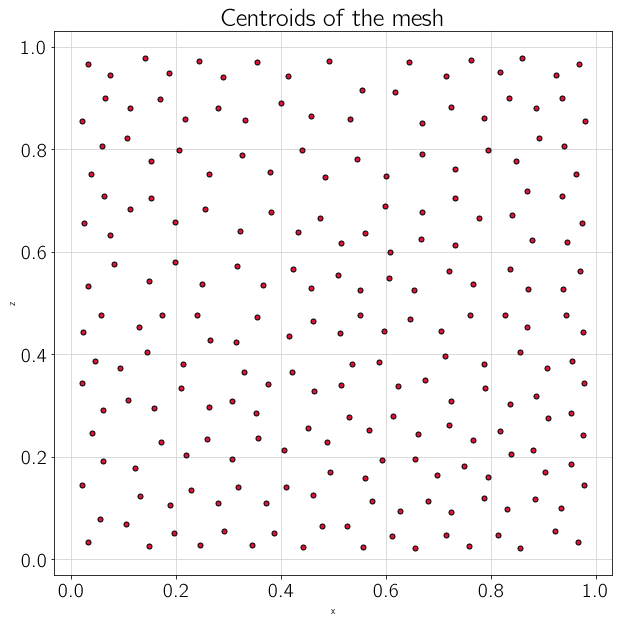

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(x[:], z[:], marker=".", c="#DC143C", edgecolors="black", s=100)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title("Centroids of the mesh", fontsize=25)
plt.show()

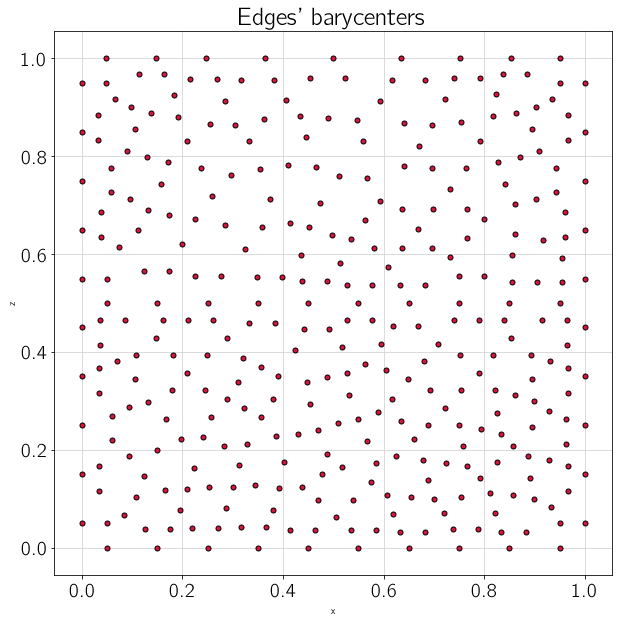

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

ax.scatter(xDual[:], zDual[:], marker=".", c="#DC143C", edgecolors="black", s=100)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.title("Edges' barycenters", fontsize=25)
plt.show()

## Interpolate results on a regular grid

https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy

#### scipy.interpolate.Rbf

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html

**function : str or callable, optional**:

`'multiquadric'`: sqrt((r/self.epsilon)**2 + 1)

`'inverse'`: 1.0/sqrt((r/self.epsilon)**2 + 1)

`'gaussian'`: exp(-(r/self.epsilon)**2)

`'linear'`: r

`'cubic'`: r**3

`'quintic'`: r**5

`'thin_plate'`: r**2 * log(r)

If callable, then it must take 2 arguments (self, r). The epsilon parameter will be available as self.epsilon. Other keyword arguments passed in will be available as well.

**epsilon : float, optional**

Adjustable constant for gaussian or multiquadrics functions - defaults to approximate average distance between nodes (which is a good start).


**smooth : float, optional**

Values greater than zero increase the smoothness of the approximation. 0 is for interpolation (default), the function will always go through the nodal points in this case.

**norm : str, callable, optional**

A function that returns the ‘distance’ between two points, with inputs as arrays of positions (x, y, z, …), and an output as an array of distance. E.g., the default: ‘euclidean’, such that the result is a matrix of the distances from each point in x1 to each point in x2. For more options, see documentation of scipy.spatial.distances.cdist.

Define the regular grid

In [10]:
x_g = y_g = np.linspace(0,1,50)
X_g, Y_g = np.meshgrid(x_g, y_g)


### Initial condition, $\psi_0$

In [11]:
zfun_smooth_rbf = interp.Rbf(x[:], z[:], ic[:], function='linear', smooth=0,epsilon=1)  # default smooth=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(X_g, Y_g)  # not really a function, but a callable class instance

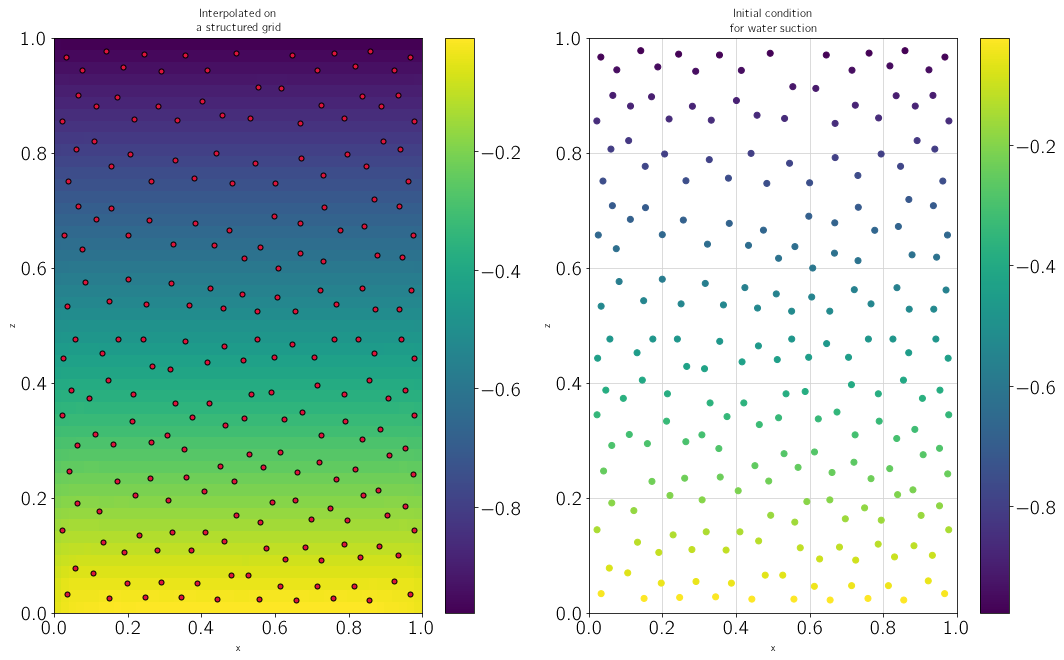

In [12]:
plt.figure(figsize=(15,15/1.618))
plt.subplot(121)
plt.pcolor(X_g,Y_g,z_dense_smooth_rbf)
plt.colorbar()
plt.scatter(x[:], z[:], marker=".", c="#DC143C", edgecolors="black", s=100)
plt.title("Interpolated on \n a structured grid")
plt.xlabel("x")
plt.ylabel("z")


plt.subplot(122)
plt.scatter(x[:], z[:], c=ic[:], cmap='viridis', vmin=min(ic[:]), vmax=max(ic[:]))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.colorbar()
plt.title("Initial condition\n for water suction")
plt.xlabel("x")
plt.ylabel("z")

plt.tight_layout()

In [18]:
timeIndex = 3

### Water suction

In [19]:
zfun_smooth_rbf = interp.Rbf(x[:], z[:], psi[timeIndex,:], function='linear', smooth=0,epsilon=1)  # default smooth=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(X_g, Y_g)  # not really a function, but a callable class instance

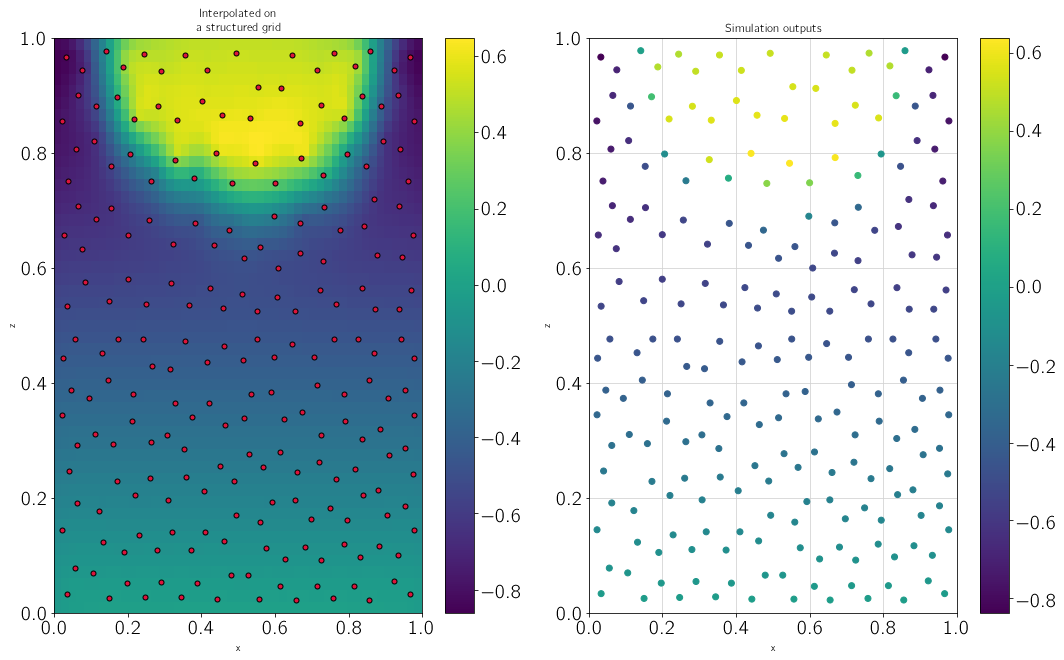

In [21]:
plt.figure(figsize=(15,15/1.618))
plt.subplot(121)
plt.pcolor(X_g,Y_g,z_dense_smooth_rbf)
plt.colorbar()
plt.scatter(x[:], z[:], marker=".", c="#DC143C", edgecolors="black", s=100)
plt.title("Interpolated on \n a structured grid")
plt.xlabel("x")
plt.ylabel("z")


plt.subplot(122)
plt.scatter(x[:], z[:], c=psi[timeIndex,:], cmap='viridis', vmin=min(psi[timeIndex,:]), vmax=max(psi[timeIndex,:]))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.colorbar()
plt.title("Simulation outputs")
plt.xlabel("x")
plt.ylabel("z")

plt.tight_layout()

### Water content

In [16]:
zfun_smooth_rbf = interp.Rbf(x[:], z[:], theta[timeIndex,:], function='linear', smooth=0,epsilon=1)  # default smooth=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(X_g, Y_g)  # not really a function, but a callable class instance

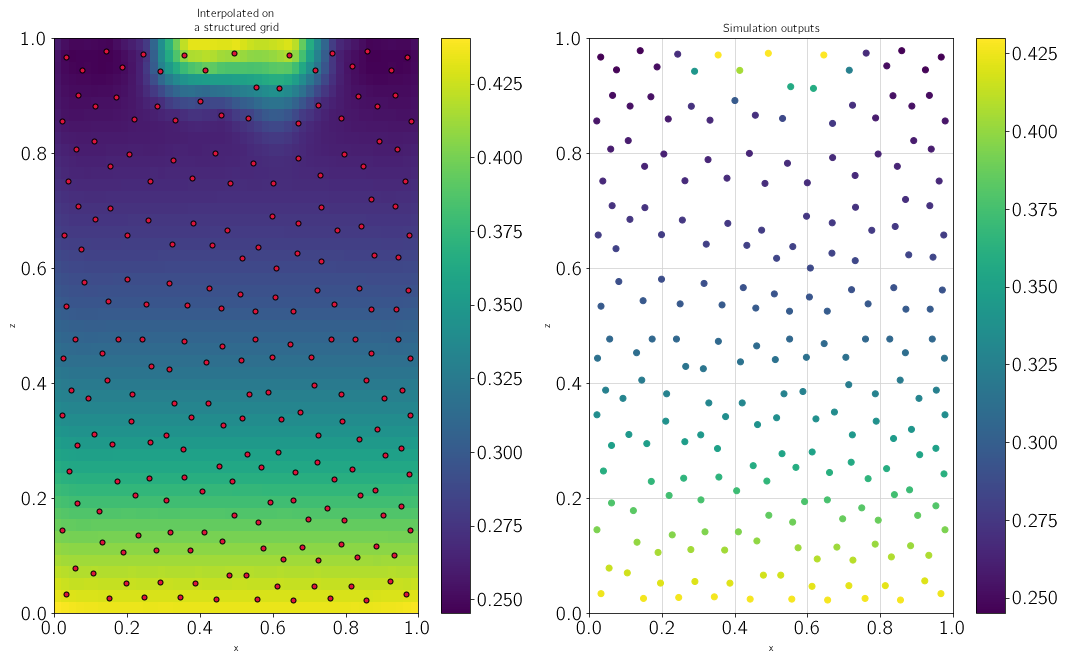

In [17]:
plt.figure(figsize=(15,15/1.618))
plt.subplot(121)
plt.pcolor(X_g,Y_g,z_dense_smooth_rbf)
plt.colorbar()
plt.scatter(x[:], z[:], marker=".", c="#DC143C", edgecolors="black", s=100)
plt.title("Interpolated on \n a structured grid")
plt.xlabel("x")
plt.ylabel("z")


plt.subplot(122)
plt.scatter(x[:], z[:], c=theta[timeIndex,:], cmap='viridis', vmin=min(theta[timeIndex,:]), vmax=max(theta[timeIndex,:]))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.colorbar()
plt.title("Simulation outputs")
plt.xlabel("x")
plt.ylabel("z")

plt.tight_layout()

### Velocities

**FIX ME**

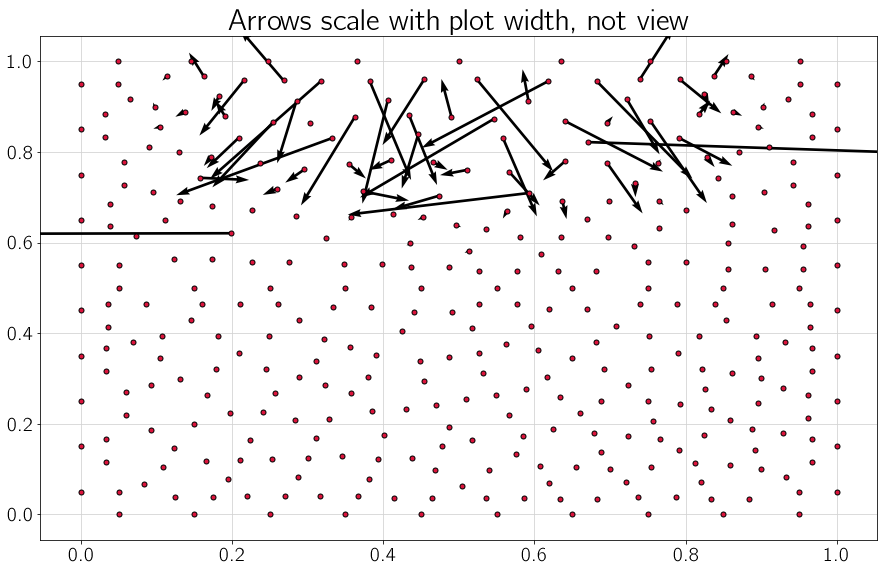

In [686]:
#timeIndex = 3
vel = (u[timeIndex,:]**2+v[timeIndex,:]**2)**0.5
U = u[timeIndex,:]
U[abs(U)<0.0000000001] = 0
U = U/vel
V = v[timeIndex,:]
V[abs(V)<0.0000000001] = 0
V = V/vel
zfun_smooth_rbf = interp.Rbf(xDual[:], zDual[:], vel, function='linear', smooth=0,epsilon=1)  # default smooth=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(X_g, Y_g)  # not really a function, but a callable class instance


fig1, ax1 = plt.subplots(figsize=(15,15/1.618))
ax1.set_title('Arrows scale with plot width, not view')
#M = np.hypot(u[timeIndex,:], v[timeIndex,:])
#C = ax1.pcolor(X_g,Y_g,z_dense_smooth_rbf)
Q = ax1.quiver(xDual[:], zDual[:], u[timeIndex,:], v[timeIndex,:], units='x',scale=1e-4)

plt.scatter(xDual[:], zDual[:], marker=".", c="#DC143C", edgecolors="black", s=100)
#qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E', coordinates='figure')